# Multiple devices processing

> [WARNING] Re-running this notebook on another system will not provide identical results.

pyclesperanto runs on OpenCL compatible devices, mainly GPUs but it can also includes CPUs. Depending on your system configuration, one or more devices can be used. This notebook simply demonstrate how to switch from one to another.

In [1]:
import pyclesperanto as cle
import numpy as np
import time

from matplotlib import pyplot as plt
from skimage import io

cle.get_device()

(OpenCL) AMD Ryzen 9 7950X 16-Core Processor (OpenCL 3.0 (Build 0))
	Vendor:                      Intel(R) Corporation
	Driver Version:              2025.20.10.0.23_160000
	Device Type:                 CPU
	Compute Units:               32
	Global Memory Size:          127926 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         63963 MB
	Max Clock Frequency:         0 MHz
	Image Support:               Yes

After importing pyclesperanto and looking at the default selected device, we have a GPU device available. But other devices might be available, and the default device is maybe not the most adapted to run image processing. 
The function `list_available_devices` and `info` can provide more info on the various available devices on the system,

In [2]:
print("available device:", cle.list_available_devices())
cle.info()

available device: ['NVIDIA GeForce RTX 4090', 'NVIDIA GeForce RTX 4090', 'AMD Ryzen 9 7950X 16-Core Processor']
0 - (OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.274.02
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24183 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         6045 MB
	Max Clock Frequency:         2520 MHz
	Image Support:               Yes
1 - (OpenCL) NVIDIA GeForce RTX 4090 (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              535.274.02
	Device Type:                 GPU
	Compute Units:               128
	Global Memory Size:          24183 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         6045 MB
	Max Clock Frequency:         2520 MHz
	Image Support:               Yes
2 - (OpenCL) AMD Ryzen 9 7950X 16-Core Processor (OpenCL 3.0 (Build 0))
	Vendor:            

This system has three devices, 2 GPUs and 1 CPU. All are ready to use, and can be selected using the function `select_device`.

In [3]:
amd_device = cle.select_device('AMD')
print(amd_device.info)

(OpenCL) AMD Ryzen 9 7950X 16-Core Processor (OpenCL 3.0 (Build 0))
	Vendor:                      Intel(R) Corporation
	Driver Version:              2025.20.10.0.23_160000
	Device Type:                 CPU
	Compute Units:               32
	Global Memory Size:          127926 MB
	Local Memory Size:           0 MB
	Maximum Buffer Size:         63963 MB
	Max Clock Frequency:         0 MHz
	Image Support:               Yes



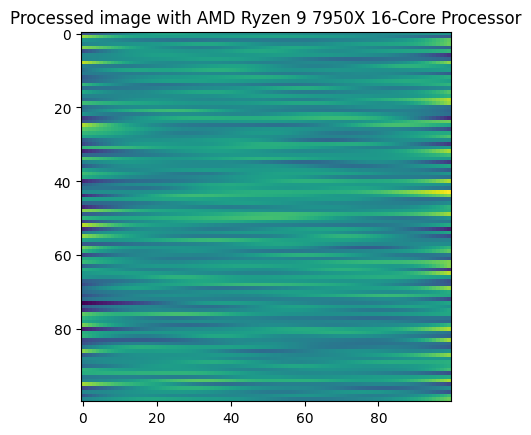

In [4]:
image = np.random.random((100, 100))
processed_image = cle.gaussian_blur(image, sigma_x=10)

fig,axs = plt.subplots(1,1)
axs.imshow(processed_image)
axs.set_title(f'Processed image with {cle.get_device().name}')
plt.show()


The last selected device is the one store in the `current_device` of the library. This device will be used by default and can be retrieved with the `get_device` function. 

It is possible to use different devices than the currently selected device. The device returned by the function `select_device` can be store and passed as an argument to pyclesperanto functions.
We can, for example, do a speed comparison between two differents devices.

In [5]:
%%timeit
cle.gaussian_blur(image, sigma_x=10, device=cle.select_device('AMD'))

160 μs ± 5.72 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
%%timeit
cle.gaussian_blur(image, sigma_x=10, device=cle.select_device('NVIDIA'))

382 μs ± 89.2 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Although, in this example, the device was specified at the operation level, this is not the recommended usage if using multiple device. Devices do not communicate together, hence trying to process a buffer on a device A with an other buffer on device B, will result in an error. We strongly encourage to specify the device at the `push` operation level. Buffer will store the device and operation will rely on this to use the correct device. This approach is safer and cleaner.

## Example of processing using multiple devices

/tmp/ipykernel_43942/2138966388.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(image)


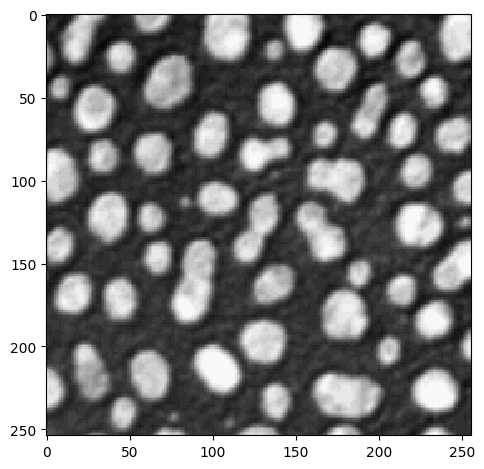

In [7]:
image = io.imread("https://samples.fiji.sc/blobs.png").squeeze()
io.imshow(image)

We push our data to the different devices. This way, operation runned on image's device.

In [8]:
image1 = cle.push(image, device=cle.select_device('AMD'))
image2 = cle.push(image, device=cle.select_device('NVIDIA'))

print("image 1:",type(image1), "device:", image1.device.name)
print("image 2:",type(image2), "device:", image2.device.name)

image 1: <class 'pyclesperanto._pyclesperanto._Array'> device: AMD Ryzen 9 7950X 16-Core Processor
image 2: <class 'pyclesperanto._pyclesperanto._Array'> device: NVIDIA GeForce RTX 4090


In [9]:
for i in range(0, 5):
    print("-------------")
    start_time = time.time()
    
    # process image on first GPU
    blurred1 = cle.gaussian_blur(image1, sigma_x=20 + i, sigma_y=20 + i)
    # retrieve result from first GPU
    result1 = cle.pull(blurred1)
    t1 = time.time() - start_time
    print("Processing and pulling on", blurred1.device.name, "took", t1)
    
    start_time = time.time()
    # process image on second GPU
    blurred2 = cle.gaussian_blur(image2, sigma_x=20 + i, sigma_y=20 + i)
    # retrieve result from second GPU
    result2 = cle.pull(blurred2)
    t2 = time.time() - start_time
    print("Processing and pulling on", blurred2.device.name, "took", t2)   

-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor took 0.006097078323364258
Processing and pulling on NVIDIA GeForce RTX 4090 took 0.0012385845184326172
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor took 0.0012660026550292969
Processing and pulling on NVIDIA GeForce RTX 4090 took 0.00046706199645996094
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor took 0.0013172626495361328
Processing and pulling on NVIDIA GeForce RTX 4090 took 0.00034117698669433594
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor took 0.0013108253479003906
Processing and pulling on NVIDIA GeForce RTX 4090 took 0.00032830238342285156
-------------
Processing and pulling on AMD Ryzen 9 7950X 16-Core Processor took 0.0013339519500732422
Processing and pulling on NVIDIA GeForce RTX 4090 took 0.0016760826110839844


We can see that the device are propagate to the output image generated by the operation.